In [124]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import datetime
import os
import copy

plt.ion()   # interactive mode

In [125]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets/tiny-imagenet-200'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes

{'train': 100000, 'val': 10000}

In [126]:
with open("datasets/tiny-imagenet-200/words.txt", 'r') as file:
    lines = file.read().split('\n')
    wnid_to_classname = dict(tuple([line.split(sep=None)[:2] for line in lines]))

wnid_to_classname

{'n00001740': 'entity',
 'n00001930': 'physical',
 'n00002137': 'abstraction,',
 'n00002452': 'thing',
 'n00002684': 'object,',
 'n00003553': 'whole,',
 'n00003993': 'congener',
 'n00004258': 'living',
 'n00004475': 'organism,',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal',
 'n00007846': 'person,',
 'n00015388': 'animal,',
 'n00017222': 'plant,',
 'n00019046': 'native',
 'n00019128': 'natural',
 'n00019613': 'substance',
 'n00020090': 'substance',
 'n00020827': 'matter',
 'n00021265': 'food,',
 'n00021734': 'nutrient',
 'n00021939': 'artifact,',
 'n00022903': 'article',
 'n00023100': 'psychological',
 'n00023271': 'cognition,',
 'n00023773': 'motivation,',
 'n00024264': 'attribute',
 'n00024720': 'state',
 'n00026192': 'feeling',
 'n00027167': 'location',
 'n00027807': 'shape,',
 'n00028270': 'time',
 'n00028651': 'space,',
 'n00029007': 'abs

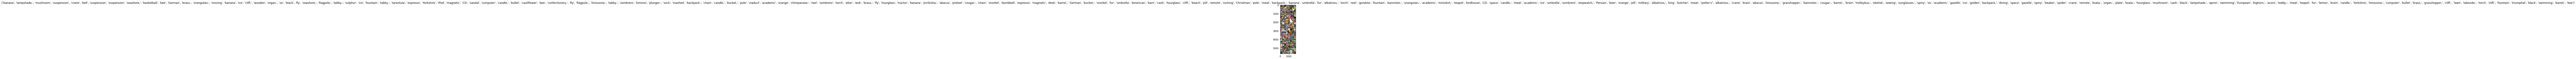

In [127]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[wnid_to_classname[class_names[x]] for x in classes])

In [133]:
PATH = "weights/torch_resnet_BEST"

# criterion is loss function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # track best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # train for num_epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a phase: train and val
        for phase in ['train', 'val']:
            if phase == 'train':
                # sets it in training mode
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # get batch
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                if i % 2 == 0:
                    time_elapsed = time.time() - since
                    print(i + 1, '/', len(dataloaders[phase]), time_elapsed, 'seconds')
                    print('ETA:', datetime.timedelta(seconds=int((time_elapsed / (i + 1)) * (len(dataloaders[phase]) - i))))
                    
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero out the previous gradient
                optimizer.zero_grad()
                
                # dunno what this `with` does
                with torch.set_grad_enabled(phase == 'train'):
                    # forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    print('Loss', loss)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), PATH)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [134]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
print('Number of classes: ', len(class_names))
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Number of classes:  200


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
1 / 500 0.703728199005127 seconds
ETA: 0:05:51
Loss tensor(5.5144, grad_fn=<NllLossBackward>)
Loss tensor(5.5195, grad_fn=<NllLossBackward>)
3 / 500 122.32423710823059 seconds
ETA: 5:38:25
Loss tensor(5.5523, grad_fn=<NllLossBackward>)
Loss tensor(5.4573, grad_fn=<NllLossBackward>)
5 / 500 220.61086320877075 seconds
ETA: 6:04:44
Loss tensor(5.5003, grad_fn=<NllLossBackward>)
Loss tensor(5.4412, grad_fn=<NllLossBackward>)
7 / 500 319.6557171344757 seconds
ETA: 6:15:58
Loss tensor(5.4753, grad_fn=<NllLossBackward>)
Loss tensor(5.5004, grad_fn=<NllLossBackward>)
9 / 500 427.7017982006073 seconds
ETA: 6:29:41
Loss tensor(5.5088, grad_fn=<NllLossBackward>)
Loss tensor(5.4649, grad_fn=<NllLossBackward>)
11 / 500 523.7446162700653 seconds
ETA: 6:28:50
Loss tensor(5.4394, grad_fn=<NllLossBackward>)
Loss tensor(5.5188, grad_fn=<NllLossBackward>)
13 / 500 632.432058095932 seconds
ETA: 6:35:40
Loss tensor(5.3642, grad_fn=<NllLossBackward>)
Loss tensor(5.4753, grad_fn=<NllLoss

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(wnid_to_classname[class_names[preds[j]]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
visualize_model(model_ft)

In [ ]:
PATH = "weights/torch_resnet"
print(model_ft.state_dict())
torch.save(model_ft.state_dict(), PATH)

In [ ]:
model_loaded = models.resnet18()
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = nn.Linear(num_ftrs, len(class_names))

model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(PATH))

# sanity check that loading the model works
for i, j in model_loaded.state_dict().items():
    if not np.all((j == model_ft.state_dict()[i]).numpy()):
        assert False
print("All clear!")